In [12]:
# install
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [85]:
# Libraries
import requests
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [32]:
# GLOBAL VARIABLES
country = 'MLM'
category = 'MLM1648'  # example_categories.json
start_offset = 0
end_offset = 1000  # 1000 top items

In [33]:
def fetch_paginated_data_to_df_filtered(category, country, start_offset, end_offset):
    """
    Fetches paginated data from the MercadoLibre API for a given category and country, 
    and returns a filtered DataFrame with specific fields.
    Parameters:
    category (str): The category ID to fetch data for.
    country (str): The country code to fetch data from.
    start_offset (int): The starting offset for pagination.
    end_offset (int): The ending offset for pagination.
    Returns:
    pd.DataFrame: A DataFrame containing the filtered data with the following fields:
        - id: The item ID.
        - seller_id: The seller's ID.
        - price: The current price of the item.
        - original_price: The original price of the item.
        - available_quantity: The available quantity of the item.
    Note:
    The function makes multiple API calls to fetch data in increments of 50 items per call.
    If an API call fails, an error message is printed with the corresponding offset.
    """
    base_url = "https://api.mercadolibre.com/sites/"
    all_data = []
    
    for offset in tqdm(range(start_offset, end_offset + 1, 50), desc="Fetching paginated data"):
        # Construct the URL with the given parameters
        url = f"{base_url}{country}/search?category={category}&offset={offset}"
        
        # Make the API call
        response = requests.get(url)
        
        # Check if the call was successful
        if response.status_code == 200:
            # Parse the JSON response
            data = response.json()
            
            # Extract the required fields
            for item in data.get('results', []):
                filtered_item = {
                    'id': item.get('id'),
                    'seller_id': item.get('seller', {}).get('id'),
                    'price': item.get('price'),
                    'original_price': item.get('original_price'),
                    'available_quantity': item.get('available_quantity'),
                }
                all_data.append(filtered_item)
        else:
            print(f"Error in the API call at offset {offset}")
    
    # Create a DataFrame from the filtered data
    df_filtered = pd.DataFrame(all_data)
    
    return df_filtered


# Call the function
df_filtered_paginated_data = fetch_paginated_data_to_df_filtered(category, country, start_offset, end_offset)
print(df_filtered_paginated_data.head())

Fetching paginated data: 100%|██████████| 21/21 [00:12<00:00,  1.75it/s]

              id   seller_id   price  original_price  available_quantity
0  MLM2023658727   581496608  6299.0          6499.0                   1
1  MLM3374476492   276696598  2185.5          2350.0                   1
2  MLM1988713103   226900267  2899.0             NaN                 500
3  MLM3414839820  1331658732  3699.0             NaN                 500
4   MLM931980768   414112680   349.0             NaN                 500


### Items metrics

In [36]:
def get_item_info(item_ids):
    """
    This script defines a function `get_item_info` that fetches information about a list of items from the MercadoLibre API.

    Function:
        get_item_info(item_ids):
            - Takes a list of item IDs as input.
            - Iterates over each item ID and sends a GET request to the MercadoLibre API to fetch item details.
            - If the response status is 200 (OK), it extracts specific fields from the JSON response and appends them to a list.
            - If the response status is not 200, it prints an error message with the status code.
            - Converts the list of item details into a pandas DataFrame and returns it.

    Example Usage:
        - The script demonstrates how to call the `get_item_info` function with a list of item IDs obtained from a DataFrame.
        - It prints the first few rows of the resulting DataFrame if it is not None.
    """
    all_response = []

    for item_id in tqdm(item_ids, desc="Fetching item info"):
        url = f"https://api.mercadolibre.com/items/{item_id}"
        response = requests.get(url)

        if response.status_code == 200:
            item_data = response.json()
            filtered_item = {
                'id': item_data.get('id'),
                'seller_id': item_data.get('seller_id'),
                'price': item_data.get('price'),
                'base_price': item_data.get('base_price'),
                'original_price': item_data.get('original_price'),
                'initial_quantity': item_data.get('initial_quantity'),
                'available_quantity': item_data.get('available_quantity'),
                'sold_quantity': item_data.get('sold_quantity'),
                'health': item_data.get('health'),
                'date_created': item_data.get('date_created'),
                'last_updated': item_data.get('last_updated')
            }
            all_response.append(filtered_item)
        else:
            print(f"Error: {response.status_code}")
    
    # Convert the response to a DataFrame
    df_item_info = pd.DataFrame(all_response)
        
    return df_item_info

# Example: Replace 'ITEM_ID' with a real ID
item_ids = df_filtered_paginated_data['id'].unique().tolist()
df_item_info = get_item_info(item_ids)

if df_item_info is not None:
    print(df_item_info.head())


Fetching item info: 100%|██████████| 985/985 [03:00<00:00,  5.47it/s]

              id   seller_id   price  base_price  original_price  \
0  MLM2023658727   581496608  6499.0      6499.0          6499.0   
1  MLM3374476492   276696598  2350.0      2350.0             NaN   
2  MLM1988713103   226900267  2899.0      2899.0             NaN   
3  MLM3414839820  1331658732  3699.0      3699.0             NaN   
4   MLM931980768   414112680   349.0       349.0             NaN   

   initial_quantity available_quantity sold_quantity  health  \
0               399               None          None     NaN   
1               916               None          None     1.0   
2              3006               None          None     NaN   
3              1123               None          None     NaN   
4             43509               None          None     NaN   

               date_created              last_updated  
0  2024-02-22T17:20:34.000Z  2024-12-10T04:07:41.965Z  
1  2024-09-23T02:18:59.069Z  2024-12-10T05:01:52.949Z  
2  2023-12-05T23:44:32.000Z  2024-12-1

In [37]:
# Perform the join of df_filtered_paginated_data with df_item_info using the 'id' column
df_items = pd.merge(df_filtered_paginated_data, df_item_info, on='id', suffixes=('_filtered', '_item_info'))

# Display the first rows of the resulting DataFrame
print(df_items.head())

              id  seller_id_filtered  price_filtered  original_price_filtered  \
0  MLM2023658727           581496608          6299.0                   6499.0   
1  MLM3374476492           276696598          2185.5                   2350.0   
2  MLM1988713103           226900267          2899.0                      NaN   
3  MLM3414839820          1331658732          3699.0                      NaN   
4   MLM931980768           414112680           349.0                      NaN   

   available_quantity_filtered  seller_id_item_info  price_item_info  \
0                            1            581496608           6499.0   
1                            1            276696598           2350.0   
2                          500            226900267           2899.0   
3                          500           1331658732           3699.0   
4                          500            414112680            349.0   

   base_price  original_price_item_info  initial_quantity  \
0      6499.0      

In [38]:
# Create a new column indicating if the original price is available
df_items['has_original_price'] = df_items['original_price_filtered'].notnull().astype(int)

# Create a new column calculating the discount percentage
df_items['discount_percentage'] = ((df_items['original_price_filtered'] - df_items['price_filtered']) / df_items['original_price_filtered']) * 100

# Fill NaN values in the discount column with 0 (no discount)
df_items['discount_percentage'].fillna(0, inplace=True)

# Create a new column indicating if the item has health information
df_items['has_health_info'] = df_items['health'].notnull().astype(int)

# Create a new column calculating the age of the item in days since it was created
df_items['item_age_days'] = (pd.to_datetime('today').tz_localize(None) - pd.to_datetime(df_items['date_created']).dt.tz_localize(None)).dt.days

print(df_items.head())

              id  seller_id_filtered  price_filtered  original_price_filtered  \
0  MLM2023658727           581496608          6299.0                   6499.0   
1  MLM3374476492           276696598          2185.5                   2350.0   
2  MLM1988713103           226900267          2899.0                      NaN   
3  MLM3414839820          1331658732          3699.0                      NaN   
4   MLM931980768           414112680           349.0                      NaN   

   available_quantity_filtered  seller_id_item_info  price_item_info  \
0                            1            581496608           6499.0   
1                            1            276696598           2350.0   
2                          500            226900267           2899.0   
3                          500           1331658732           3699.0   
4                          500            414112680            349.0   

   base_price  original_price_item_info  initial_quantity  \
0      6499.0      

In [39]:
# Group by seller_id and calculate metrics
seller_metrics = df_items.groupby('seller_id_filtered').agg({
    'id': 'count',  # Number of items
    'price_filtered': ['mean', 'min', 'max'],  # Average, minimum, and maximum price
    'original_price_filtered': ['mean', 'min', 'max'],  # Average, minimum, and maximum original price
    'available_quantity_filtered': 'sum',  # Total available quantity
    'discount_percentage': ['mean', 'min', 'max'],  # Average, minimum, and maximum discount percentage
    'health': ['mean', 'min', 'max'],  # Average, minimum, and maximum health
    'item_age_days': ['mean', 'min', 'max']  # Average, minimum, and maximum item age in days
}).reset_index()

# Rename columns for better readability
seller_metrics.columns = ['seller_id', 'item_count', 'avg_price', 'min_price', 'max_price', 
                          'avg_original_price', 'min_original_price', 'max_original_price', 
                          'total_available_quantity', 'avg_discount_percentage', 
                          'min_discount_percentage', 'max_discount_percentage',
                          'avg_health', 'min_health', 'max_health', 
                          'avg_item_age_days', 'min_item_age_days', 'max_item_age_days']

print(seller_metrics.head())

   seller_id  item_count  avg_price  min_price  max_price  avg_original_price  \
0    4881115           1   249.0000     249.00     249.00                 NaN   
1   10265533           2   496.9950     495.00     498.99                 NaN   
2   23299053           1   470.2500     470.25     470.25             495.000   
3   23838355          32  9589.5625    5679.29   19599.00           13270.875   
4   25926835           1    64.9900      64.99      64.99                 NaN   

   min_original_price  max_original_price  total_available_quantity  \
0                 NaN                 NaN                       500   
1                 NaN                 NaN                         2   
2               495.0               495.0                         1   
3              7999.0             26999.0                      1419   
4                 NaN                 NaN                        50   

   avg_discount_percentage  min_discount_percentage  max_discount_percentage  \
0     

### Seller data

In [40]:
def get_seller_info(seller_ids):
    all_seller_data = []

    for seller_id in tqdm(seller_ids, desc="Fetching seller info"):
        url = f"https://api.mercadolibre.com/users/{seller_id}"
        response = requests.get(url)

        if response.status_code == 200:
            seller_data = response.json()
            filtered_seller_data = {
                'id': seller_data.get('id'),
                'nickname': seller_data.get('nickname'),
                'user_type': seller_data.get('user_type'),
                'site_id': seller_data.get('site_id'),
                'permalink': seller_data.get('permalink'),
                'level_id': seller_data.get('seller_reputation', {}).get('level_id'),
                'power_seller_status': seller_data.get('seller_reputation', {}).get('power_seller_status'),
                'transactions_total': seller_data.get('seller_reputation', {}).get('transactions', {}).get('total'),
                'status': seller_data.get('status', {}).get('site_status')
            }
            all_seller_data.append(filtered_seller_data)
        else:
            print(f"Error: {response.status_code} for seller_id {seller_id}")

    # Convert the list of seller data to a DataFrame
    df_seller_info = pd.DataFrame(all_seller_data)
    
    return df_seller_info

# Example usage: Replace 'SELLER_ID_LIST' with a real list of seller IDs
seller_ids = seller_metrics['seller_id'].unique().tolist()
df_seller_info = get_seller_info(seller_ids)

if df_seller_info is not None:
    print(df_seller_info.head())

Fetching seller info: 100%|██████████| 426/426 [01:16<00:00,  5.59it/s]

         id                nickname user_type site_id  \
0   4881115             ZUGARS GAME    normal     MLM   
1  10265533                  RYSCOM     brand     MLM   
2  23299053                  DALKOM    normal     MLM   
3  23838355              GRUPODECME     brand     MLM   
4  25926835  RIVA IMPORTACIONES.GDL    normal     MLM   

                                           permalink level_id  \
0      http://perfil.mercadolibre.com.mx/ZUGARS+GAME  5_green   
1           http://perfil.mercadolibre.com.mx/RYSCOM  5_green   
2           http://perfil.mercadolibre.com.mx/DALKOM  5_green   
3       http://perfil.mercadolibre.com.mx/GRUPODECME  5_green   
4  http://perfil.mercadolibre.com.mx/RIVA+IMPORTA...  5_green   

  power_seller_status  transactions_total  status  
0            platinum               43038  active  
1            platinum               10856  active  
2            platinum                7448  active  
3            platinum              230017  active  
4     

In [41]:
# Perform the join of df_seller_info with seller_metrics using the 'seller_id' column
df_seller_final = pd.merge(df_seller_info, seller_metrics, left_on='id', right_on='seller_id')

# Display the first rows of the resulting DataFrame
print(df_seller_final.head())

         id                nickname user_type site_id  \
0   4881115             ZUGARS GAME    normal     MLM   
1  10265533                  RYSCOM     brand     MLM   
2  23299053                  DALKOM    normal     MLM   
3  23838355              GRUPODECME     brand     MLM   
4  25926835  RIVA IMPORTACIONES.GDL    normal     MLM   

                                           permalink level_id  \
0      http://perfil.mercadolibre.com.mx/ZUGARS+GAME  5_green   
1           http://perfil.mercadolibre.com.mx/RYSCOM  5_green   
2           http://perfil.mercadolibre.com.mx/DALKOM  5_green   
3       http://perfil.mercadolibre.com.mx/GRUPODECME  5_green   
4  http://perfil.mercadolibre.com.mx/RIVA+IMPORTA...  5_green   

  power_seller_status  transactions_total  status  seller_id  ...  \
0            platinum               43038  active    4881115  ...   
1            platinum               10856  active   10265533  ...   
2            platinum                7448  active   2329905

In [45]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

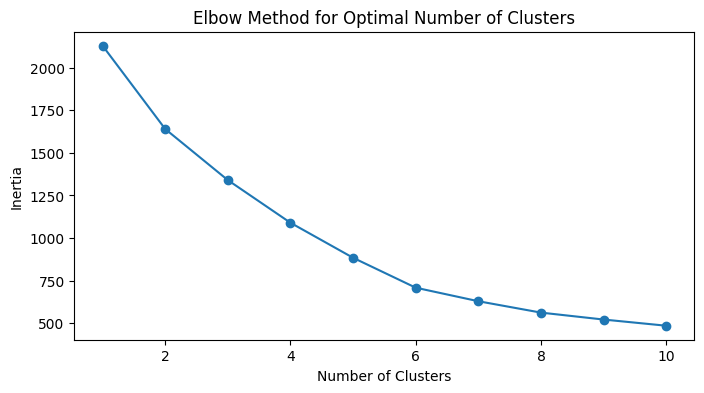

In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select relevant features for clustering
features = ['item_count', 'avg_price', 'avg_discount_percentage', 'avg_health', 'avg_item_age_days']

# Preprocess the data: fill NaN values with 0 and standardize the features
df_seller_final[features] = df_seller_final[features].fillna(0)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_seller_final[features])

# Determine the optimal number of clusters using the elbow method
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


In [87]:
# Fit the KMeans model with the optimal number of clusters (e.g., 6)
kmeans = KMeans(n_clusters=6, random_state=42)
df_seller_final['cluster'] = kmeans.fit_predict(scaled_features)

In [88]:
# Group by the 'cluster' column and calculate metrics
cluster_metrics = df_seller_final.groupby('cluster').agg({
    'item_count': ['mean', 'min', 'max'],
    'avg_price': ['mean', 'min', 'max'],
    'avg_discount_percentage': ['mean', 'min', 'max'],
    'avg_health': ['mean', 'min', 'max'],
    'avg_item_age_days': ['mean', 'min', 'max']
}).reset_index()

# Rename columns for better clarity
cluster_metrics.columns = ['cluster', 'mean_item_count', 'min_item_count', 'max_item_count',
                           'mean_avg_price', 'min_avg_price', 'max_avg_price',
                           'mean_avg_discount_percentage', 'min_avg_discount_percentage', 'max_avg_discount_percentage',
                           'mean_avg_health', 'min_avg_health', 'max_avg_health',
                           'mean_avg_item_age_days', 'min_avg_item_age_days', 'max_avg_item_age_days']

# Display the metrics grouped by cluster
cluster_metrics

,cluster,mean_item_count,min_item_count,max_item_count,mean_avg_price,min_avg_price,max_avg_price,mean_avg_discount_percentage,min_avg_discount_percentage,max_avg_discount_percentage,mean_avg_health,min_avg_health,max_avg_health,mean_avg_item_age_days,min_avg_item_age_days,max_avg_item_age_days
0,0,1.508772,1,8,831.692008,49.060000,5614.525000,2.736612,0.000000,20.000000,0.000000,0.00,0.00,222.407554,3.0,844.500000
1,1,1.551724,1,8,822.765632,69.300000,5591.000000,4.668106,0.000000,30.000000,0.780747,0.00,1.00,1291.239943,741.0,2971.000000
2,2,1.739583,1,8,959.984569,69.000000,7051.613333,40.248000,21.225047,75.250000,0.013854,0.00,0.75,180.599293,6.0,1033.000000
3,3,17.500000,10,32,1892.910866,113.857273,9589.562500,7.710499,0.000000,30.454545,0.260139,0.00,0.87,354.876871,62.7,873.655172
4,4,4.000000,1,12,11348.967218,6385.000000,30176.360000,12.889595,0.000000,47.500000,0.217912,0.00,1.00,265.186248,9.0,690.166667
5,5,2.184783,1,9,1742.844198,96.200000,7989.060000,17.305260,0.000000,62.000000,0.888360,0.64,1.00,320.106052,14.0,867.000000


In [89]:
# Map cluster labels to descriptive names
cluster_mapping = {
    0: 'Niche Artisans',
    1: 'Seasoned Veterans',
    2: 'Deal Dynamos',
    3: 'Sales Surge Specialists',
    4: 'Premium Pioneers',
    5: 'Customer Experience Champions'
}
df_seller_final['cluster_label'] = df_seller_final['cluster'].map(cluster_mapping)

# Display the first rows of the resulting DataFrame
print(df_seller_final[['id', 'nickname', 'cluster_label']].head())

         id                nickname            cluster_label
0   4881115             ZUGARS GAME           Niche Artisans
1  10265533                  RYSCOM           Niche Artisans
2  23299053                  DALKOM           Niche Artisans
3  23838355              GRUPODECME  Sales Surge Specialists
4  25926835  RIVA IMPORTACIONES.GDL           Niche Artisans


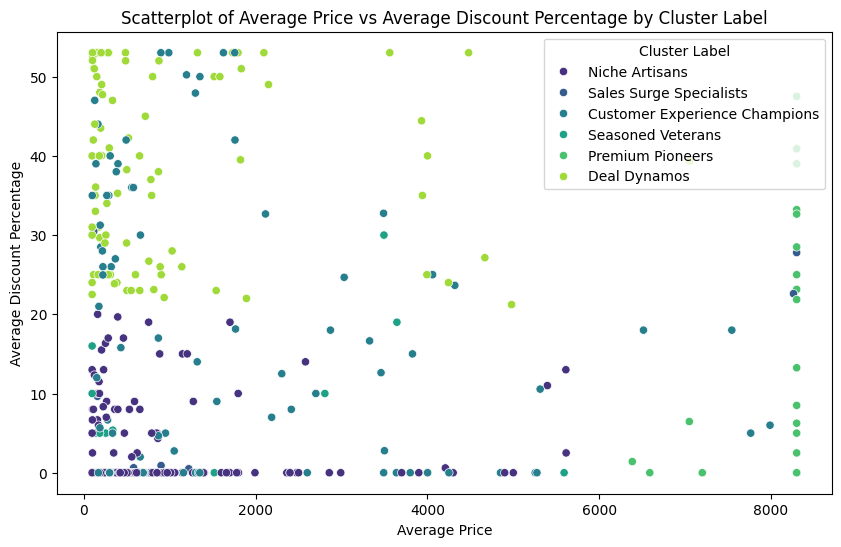

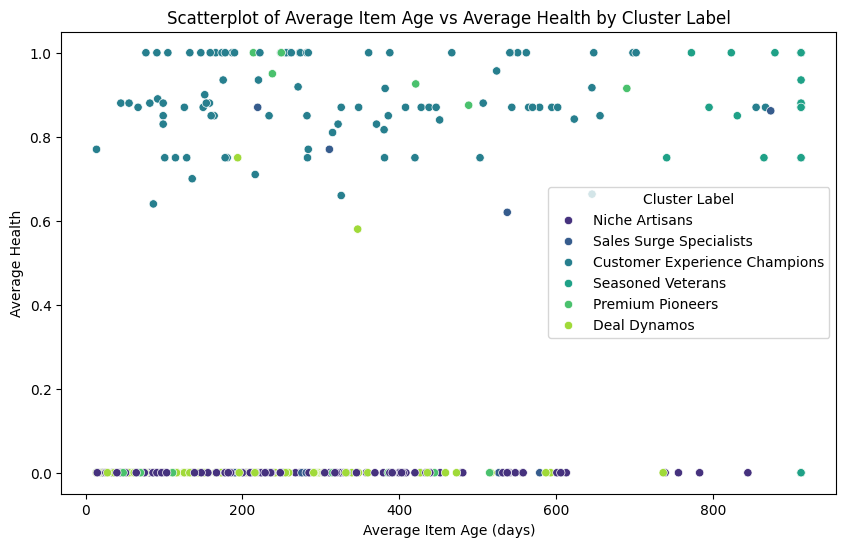

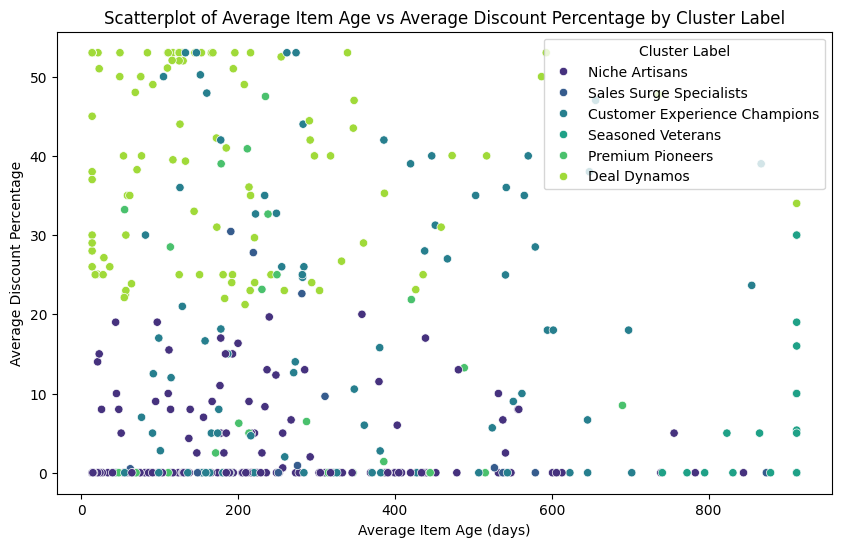

In [107]:
import os

# Create folder 'images' if not exists
if not os.path.exists('images'):
    os.makedirs('images')

# Clip the data to remove extreme values for other columns
df_seller_final['avg_price'] = df_seller_final['avg_price'].clip(lower=df_seller_final['avg_price'].quantile(0.05), upper=df_seller_final['avg_price'].quantile(0.95))
df_seller_final['avg_discount_percentage'] = df_seller_final['avg_discount_percentage'].clip(lower=df_seller_final['avg_discount_percentage'].quantile(0.05), upper=df_seller_final['avg_discount_percentage'].quantile(0.95))
df_seller_final['avg_item_age_days'] = df_seller_final['avg_item_age_days'].clip(lower=df_seller_final['avg_item_age_days'].quantile(0.05), upper=df_seller_final['avg_item_age_days'].quantile(0.95))
df_seller_final['avg_health'] = df_seller_final['avg_health'].clip(lower=df_seller_final['avg_health'].quantile(0.05), upper=df_seller_final['avg_health'].quantile(0.95))

# Create a scatter plot of avg_price vs avg_discount_percentage colored by cluster_label
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_seller_final, x='avg_price', y='avg_discount_percentage', hue='cluster_label', palette='viridis')
plt.xlabel('Average Price')
plt.ylabel('Average Discount Percentage')
plt.title('Scatterplot of Average Price vs Average Discount Percentage by Cluster Label')
plt.legend(title='Cluster Label')
plt.savefig('images/kmeans_Scatterplot of Average Price vs Average Discount Percentage by Cluster Label.png')
plt.show()

# Create a scatter plot of avg_item_age_days vs avg_health colored by cluster_label
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_seller_final, x='avg_item_age_days', y='avg_health', hue='cluster_label', palette='viridis')
plt.xlabel('Average Item Age (days)')
plt.ylabel('Average Health')
plt.title('Scatterplot of Average Item Age vs Average Health by Cluster Label')
plt.legend(title='Cluster Label')
plt.savefig('images/kmeans_Scatterplot of Average Item Age vs Average Health by Cluster Label.png')
plt.show()

# Create a scatter plot of avg_item_age_days vs avg_item_count colored by cluster_label
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_seller_final, x='avg_item_age_days', y='avg_discount_percentage', hue='cluster_label', palette='viridis')
plt.xlabel('Average Item Age (days)')
plt.ylabel('Average Discount Percentage')
plt.title('Scatterplot of Average Item Age vs Average Discount Percentage by Cluster Label')
plt.legend(title='Cluster Label')
plt.savefig('images/kmeans_Scatterplot of Average Item Age vs Average Discount Percentage by Cluster Label.png')
plt.show()

### Manual clusterization

In [77]:
# Define the conditions
conditions = [
    (df_seller_final['item_count'] < 20) & ((df_seller_final['avg_health'] > 0.85) | df_seller_final['avg_health'].isnull()),
    (df_seller_final['item_count'].between(30, 300)) & ((df_seller_final['avg_discount_percentage'] > 5) | df_seller_final['avg_discount_percentage'].isnull()),
    (df_seller_final['level_id'].isin(['5_green', '4_light_green'])) & 
    (df_seller_final['power_seller_status'].isin(['platinum', 'gold'])) & 
    (df_seller_final['item_count'] > 10) & 
    ((df_seller_final['avg_health'] > 0.85) | df_seller_final['avg_health'].isnull()),
    (df_seller_final['level_id'].isin(['1_red', '2_orange'])) & ((df_seller_final['avg_health'] < 0.7) | df_seller_final['avg_health'].isnull()),
    (df_seller_final['item_count'] < 15) & (df_seller_final['avg_item_age_days'] < (6 * 28))
]

# Define the corresponding labels
choices = ['Specialized', 'Competitive', 'High-Quality', 'High-Risk', 'New Player']

# Apply the conditions and choices to create the new column
df_seller_final['manual_cluster'] = np.select(conditions, choices, default='Not Identified')

# Display the first rows of the resulting DataFrame
print(df_seller_final[['id', 'nickname', 'manual_cluster']].head())

         id                nickname  manual_cluster
0   4881115             ZUGARS GAME      New Player
1  10265533                  RYSCOM      New Player
2  23299053                  DALKOM  Not Identified
3  23838355              GRUPODECME     Competitive
4  25926835  RIVA IMPORTACIONES.GDL  Not Identified


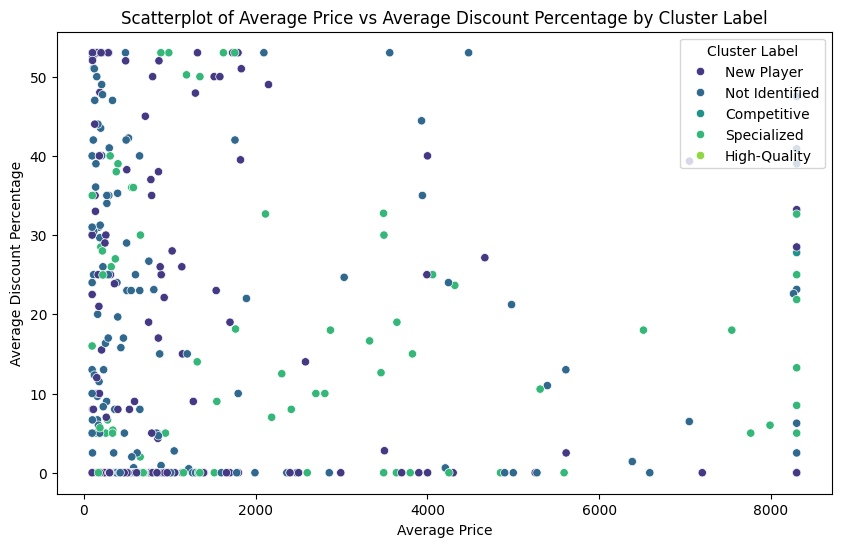

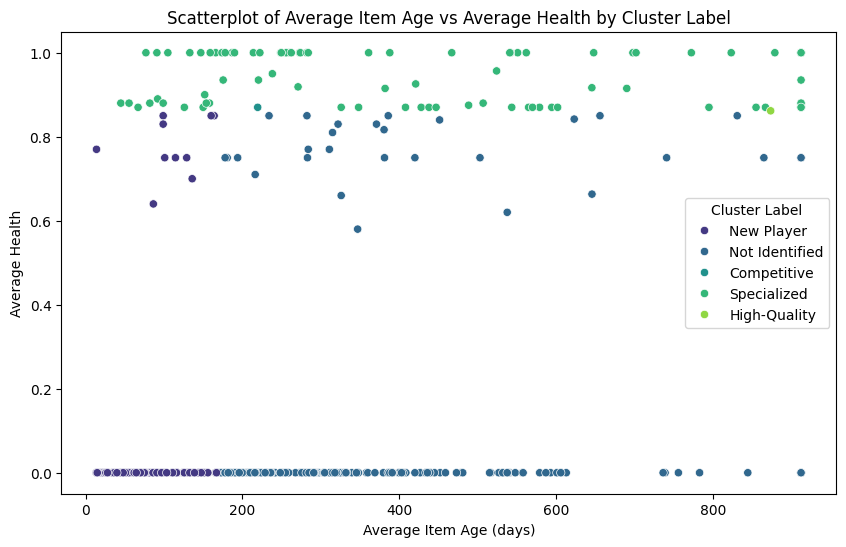

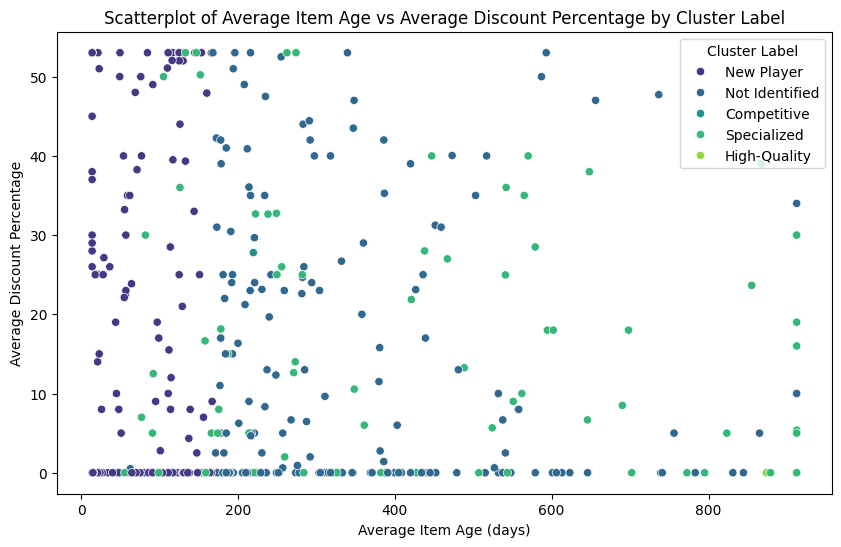

In [106]:
import os

# Create folder 'images' if not exists
if not os.path.exists('images'):
    os.makedirs('images')

# Clip the data to remove extreme values for other columns
df_seller_final['avg_price'] = df_seller_final['avg_price'].clip(lower=df_seller_final['avg_price'].quantile(0.05), upper=df_seller_final['avg_price'].quantile(0.95))
df_seller_final['avg_discount_percentage'] = df_seller_final['avg_discount_percentage'].clip(lower=df_seller_final['avg_discount_percentage'].quantile(0.05), upper=df_seller_final['avg_discount_percentage'].quantile(0.95))
df_seller_final['avg_item_age_days'] = df_seller_final['avg_item_age_days'].clip(lower=df_seller_final['avg_item_age_days'].quantile(0.05), upper=df_seller_final['avg_item_age_days'].quantile(0.95))
df_seller_final['avg_health'] = df_seller_final['avg_health'].clip(lower=df_seller_final['avg_health'].quantile(0.05), upper=df_seller_final['avg_health'].quantile(0.95))

# Create a scatter plot of avg_price vs avg_discount_percentage colored by manual_cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_seller_final, x='avg_price', y='avg_discount_percentage', hue='manual_cluster', palette='viridis')
plt.xlabel('Average Price')
plt.ylabel('Average Discount Percentage')
plt.title('Scatterplot of Average Price vs Average Discount Percentage by Cluster Label')
plt.legend(title='Cluster Label')
plt.savefig('images/manual_Scatterplot of Average Price vs Average Discount Percentage by Cluster Label.png')
plt.show()

# Create a scatter plot of avg_item_age_days vs avg_health colored by manual_cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_seller_final, x='avg_item_age_days', y='avg_health', hue='manual_cluster', palette='viridis')
plt.xlabel('Average Item Age (days)')
plt.ylabel('Average Health')
plt.title('Scatterplot of Average Item Age vs Average Health by Cluster Label')
plt.legend(title='Cluster Label')
plt.savefig('images/manual_Scatterplot of Average Item Age vs Average Health by Cluster Label.png')
plt.show()

# Create a scatter plot of avg_item_age_days vs avg_item_count colored by manual_cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_seller_final, x='avg_item_age_days', y='avg_discount_percentage', hue='manual_cluster', palette='viridis')
plt.xlabel('Average Item Age (days)')
plt.ylabel('Average Discount Percentage')
plt.title('Scatterplot of Average Item Age vs Average Discount Percentage by Cluster Label')
plt.legend(title='Cluster Label')
plt.savefig('images/manual_Scatterplot of Average Item Age vs Average Discount Percentage by Cluster Label.png')
plt.show()

### Model Evaluation

In [109]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score for the clusters
silhouette_avg = silhouette_score(scaled_features, df_seller_final['cluster'])

print(f"The average silhouette score for the clusters is: {silhouette_avg}")

The average silhouette score for the clusters is: 0.39942183072507187


### PPT data

In [108]:
# Calculate the percentage of sellers for each cluster_label
seller_percentage = df_seller_final['cluster_label'].value_counts(normalize=True) * 100

# Display the percentage of sellers for each cluster_label
print(seller_percentage)

cluster_label
Niche Artisans                   40.140845
Deal Dynamos                     22.535211
Customer Experience Champions    21.596244
Seasoned Veterans                 6.807512
Premium Pioneers                  6.103286
Sales Surge Specialists           2.816901
Name: proportion, dtype: float64
